# Первичный анализ и селекция данных
Подготовил: Глазунов А.В.

В данном блокноте опишу основные моменты, на которые я обратил внимание при первичном анализе данных и в своих попытках автоматически отобрать признаки.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mf-accelerator/contest_test.csv
/kaggle/input/mf-accelerator/sample_subm.csv
/kaggle/input/mf-accelerator/contest_train.csv


In [35]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Загрузка данных

In [3]:
data = pd.read_csv("../input/mf-accelerator/contest_train.csv")
data.head()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,0d1c880d23ff018,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,1579ba37fd82c1f,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,790086f721c7f5e,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,b0a2078cf33c226,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,d0c46717b9cb323,0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


Отберем признаки

In [4]:
features = data.drop(columns=["ID","TARGET"])
features.head()

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,NaN,3.0,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,NaN,3.0,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


In [5]:
target = data.TARGET

Подсчитаем количества уникальных значений и посмотрим на признаки, где оно минимально

In [6]:
count_dict = {}
for col in features.columns:
    count_dict[col] = [features[col].unique().shape[0]]
feats_counts = pd.DataFrame(count_dict).T
feats_counts.columns=["counts"]
feats_counts.head()

,counts
FEATURE_0,160
FEATURE_1,22
FEATURE_2,2
FEATURE_3,1
FEATURE_4,2


In [7]:
sorted_feats = feats_counts.copy().sort_values(by=["counts"])

Признаки, где только 1 значение

In [8]:
sorted_feats[sorted_feats.counts < 2].index

Index(['FEATURE_249', 'FEATURE_3', 'FEATURE_256', 'FEATURE_144'], dtype='object')

Признаки, где 3 значения

In [9]:
sorted_feats[sorted_feats.counts == 3].index

Index(['FEATURE_207', 'FEATURE_205', 'FEATURE_204', 'FEATURE_123',
       'FEATURE_259', 'FEATURE_208', 'FEATURE_131', 'FEATURE_257',
       'FEATURE_156'],
      dtype='object')

Проверим, похожи ли распределения на таргет, вдруг можно построить разделение по класса, используя только эти признаки?

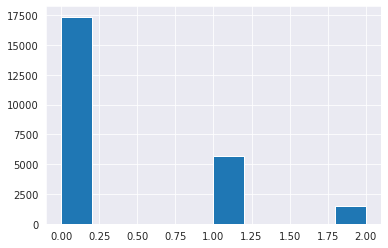

In [10]:
data.TARGET.hist()

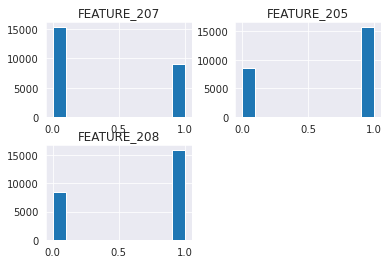

In [11]:
features[["FEATURE_207","FEATURE_205","FEATURE_208"]].hist();

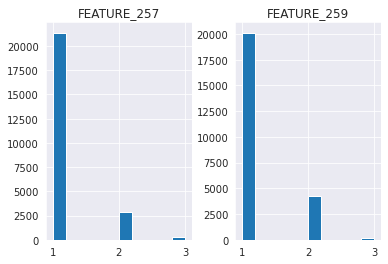

In [12]:
features[["FEATURE_257","FEATURE_259"]].hist();

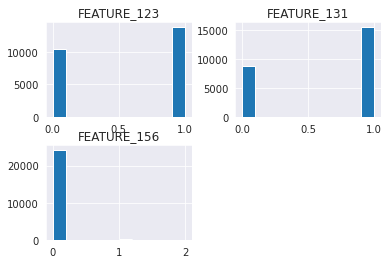

In [13]:
features[["FEATURE_123","FEATURE_131","FEATURE_156"]].hist();

К сожалению, эти признаки не настолько информативны.

Посмотрим на количество пропусков (желтое на диаграмме)

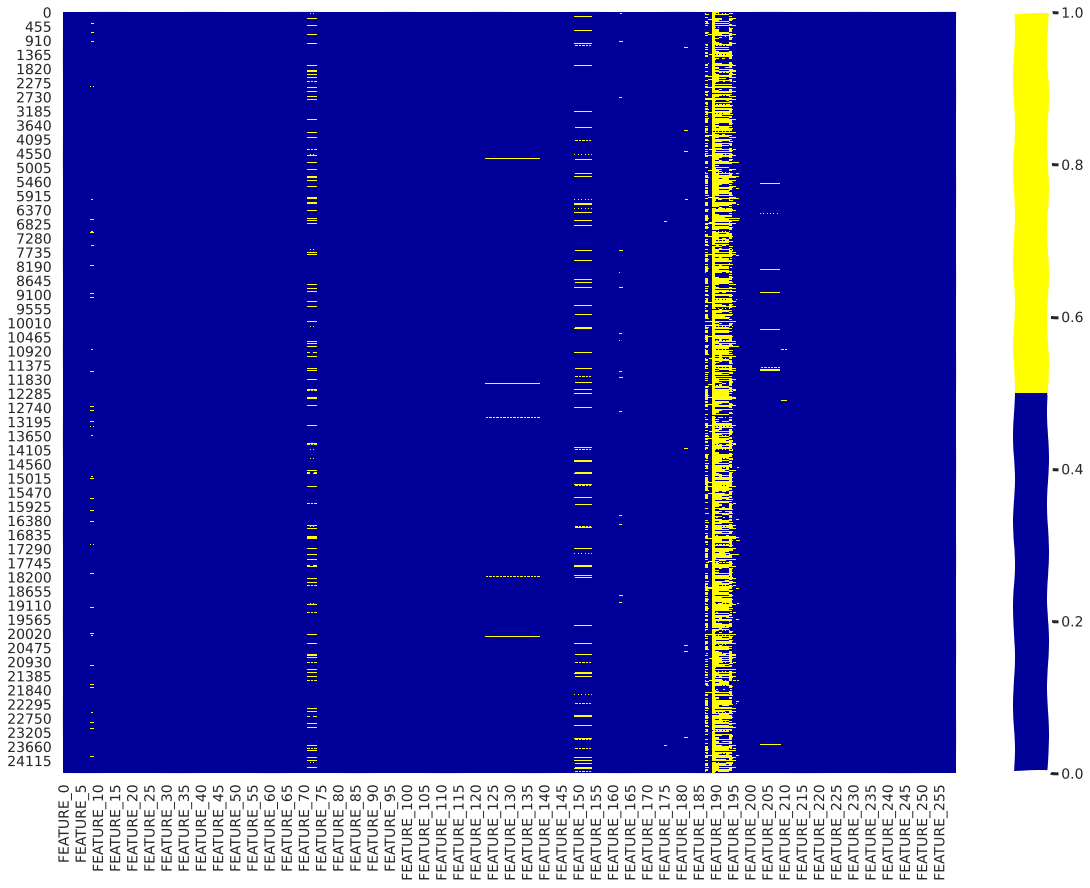

In [14]:
def null_map(data):
    data_to_heat = data.isnull()
    data_to_heat.head()
    with plt.xkcd():
        plt.figure(figsize=(20,14))
        colors = ['#000099', '#ffff00'] 
        sns.heatmap(data_to_heat,cmap = sns.color_palette(colors));
        
null_map(features)

Определим, какие признаки удалить.

In [17]:
na_prop_dict = {}
for col in features.columns:
    na_prop_dict[col] = [features[col].isnull().astype(int).mean()]
feats_na_prop = pd.DataFrame(na_prop_dict).T
feats_na_prop.columns=["NAN_prop"]
sorted_feats_nan_prop = feats_na_prop.copy().sort_values(by=["NAN_prop"],ascending=False)
sorted_feats_nan_prop.head()

,NAN_prop
FEATURE_189,0.986746
FEATURE_194,0.703275
FEATURE_190,0.701113
FEATURE_191,0.624322
FEATURE_192,0.532605


In [18]:
sorted_feats_nan_prop[sorted_feats_nan_prop.NAN_prop > 0.5]

,NAN_prop
FEATURE_189,0.986746
FEATURE_194,0.703275
FEATURE_190,0.701113
FEATURE_191,0.624322
FEATURE_192,0.532605
FEATURE_193,0.513682


Удаляем 189.

In [19]:
features_new = features.copy().drop(columns = ['FEATURE_249', 'FEATURE_3', 'FEATURE_256', 'FEATURE_144',"FEATURE_189"])
features_new.head()

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,...,FEATURE_248,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259
0,2.0,2.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,0.0,...,19.0,39.0,2.0,223.118594,290.015143,1.0,1.0,1.0,2.0,2.0
1,1.0,1.0,0.0,1.0,0.0,0.0,329.828334,NaN,3.0,2.0,...,1.0,25.0,82.0,479.616045,611.651594,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,0.0,...,78.0,119.0,0.0,352.268014,564.573421,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,0.0,...,0.0,1.0,0.0,410.524985,421.653876,1.0,0.0,1.0,2.0,2.0
4,4.0,3.0,1.0,1.0,0.0,0.0,677.745861,NaN,3.0,2.0,...,0.0,21.0,0.0,439.171356,476.189288,1.0,1.0,1.0,1.0,1.0


Отберем независимые признаки с помощью линейной регрессии.

In [20]:
def LR_feature_selection(features,max_R2=0.9):
    '''
    Функция, которая строит LR каждого признака на все остальные
    и убирает признаки, где R2 > max_R2
    Возвращает итоговые признаки и таблицу R2
    '''
    features = features.copy().fillna(0)

    features_list = list(features.columns)
    R2s = {}
    for col in tqdm_notebook(features.columns):

        model = LinearRegression()
        X = features[features_list].drop(columns = [col])
        y = features[col]

        model.fit(X,y)

        R2 = model.score(X,y)
        R2s[col] = [R2]

        if R2 > max_R2:
            features_list = list(features[features_list].drop(columns = [col]).columns)

    R2_df = pd.DataFrame(R2s).T
    R2_df.columns=["R2"]

    return features[features_list],R2_df

In [21]:
feats_selected, R2_df = LR_feature_selection(features_new)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


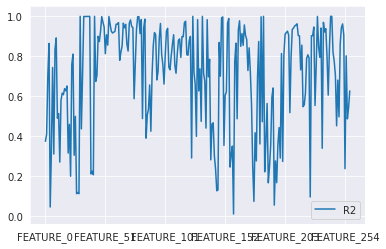

In [22]:
R2_df.plot()

На графике видено, что очень много зависимых признаков, их не будем брать дальше.

Мы удалили из рассмотрения почти 100 признаков, осталось:

In [25]:
feats_selected.shape[1]

171

In [26]:
feats_selected.head()

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,...,FEATURE_245,FEATURE_246,FEATURE_247,FEATURE_248,FEATURE_250,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259
0,2.0,2.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,0.0,...,0.0,2.0,0.0,19.0,39.0,1.0,1.0,1.0,2.0,2.0
1,1.0,1.0,0.0,1.0,0.0,0.0,329.828334,0.000000,3.0,2.0,...,0.0,0.0,0.0,1.0,25.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,0.0,...,0.0,0.0,0.0,78.0,119.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0
4,4.0,3.0,1.0,1.0,0.0,0.0,677.745861,0.000000,3.0,2.0,...,0.0,0.0,0.0,0.0,21.0,1.0,1.0,1.0,1.0,1.0


Теперь возьмем только те признаки, которые наиболее связаны с таргетом. Для этого будет строить random_forest для каждого признака по очереди. 

Отмечу,что здесь мы автоматически потеряем возможность найти и использовать более сложные зависимости между признаками, но все равно, посмотрим, что будет.

In [27]:
def RF_feature_selection_validation(features_train,target_train,features_val,target_val, min_metric = 0.01):
    '''
    Строит RF классификатор таргета по каждому из признаков 
    отдельно, отбирая признаки, проверяет на валидации 

    Выводит список отобранных признаков и значения метрики
    '''
    assert len(features_train.columns) == len(features_val.columns) 


    features_train = features_train.copy().fillna(0)
    target_train = target_train.copy()

    features_val = features_val.copy().fillna(0)
    target_val = target_val.copy()

    features_list = list(features_train.columns)
    metric_values = {}
    for col in tqdm_notebook(features_train.columns):

        model = RandomForestClassifier(n_estimators=10,n_jobs=-1)
        X = features_train[[col]]
        y = target_train

        model.fit(X,y)

        predictions = model.predict(features_val[[col]])

        metric = f1_score(target_val, predictions,average='macro')
    
        metric_values[col] = [metric]

        if metric < min_metric:
            features_list = list(features_train[features_list].drop(columns = [col]).columns)

    metric_values = pd.DataFrame(metric_values).T
    metric_values.columns=["f1_average"]

    return features_list, metric_values

Получим обучение и валидацию

In [30]:
feats_train,feats_val,labels_train,labels_val = train_test_split(feats_selected,target, test_size = 0.3,\
                                                                   shuffle=True,random_state=42,\
                                                                   stratify = target)

Запустим алгоритм отбора

In [31]:
features_selectedRF,metric_values = RF_feature_selection_validation(feats_train,labels_train,
                                                                      feats_val,labels_val,
                                                                      min_metric = 0.3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


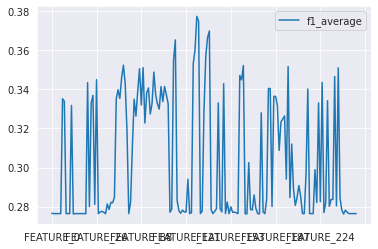

In [32]:
metric_values.plot()

Видно, что прямая связь с таргетом есть только у небольшого числа признаков.

In [33]:
len(features_selectedRF)

69

Теперь попробуем визуализировать данные на плоскости, сначала через 2 главные компоненты, а затем с помощью уже нелинейного способа уменьшения размерности tsne

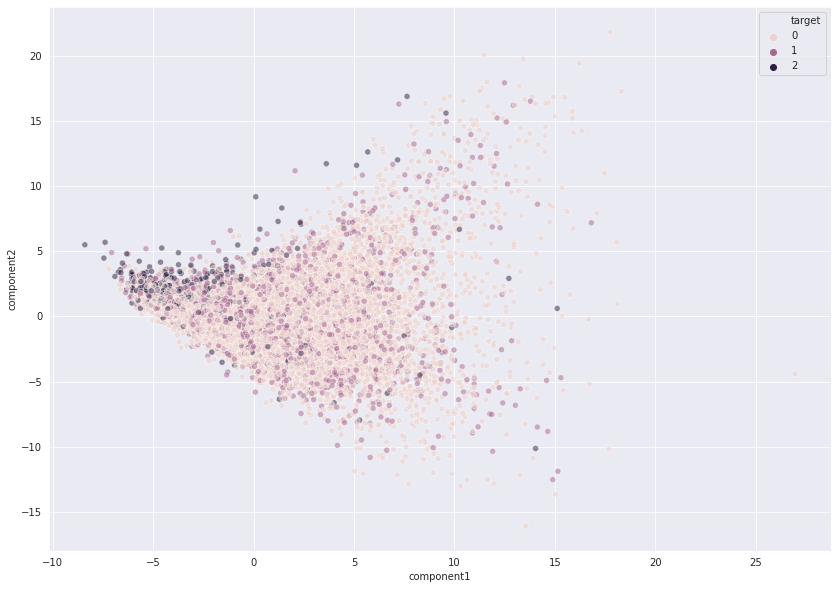

In [37]:
X_scaled = StandardScaler().fit_transform(data[features_selectedRF].copy().fillna(0))

X_pca =  PCA(n_components=2).fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca,columns=["component1","component2"])
pca_df['target'] = target
plt.figure(figsize=(14,10))
sns.scatterplot(data=pca_df, x="component1", y="component2", hue="target",alpha=0.5)

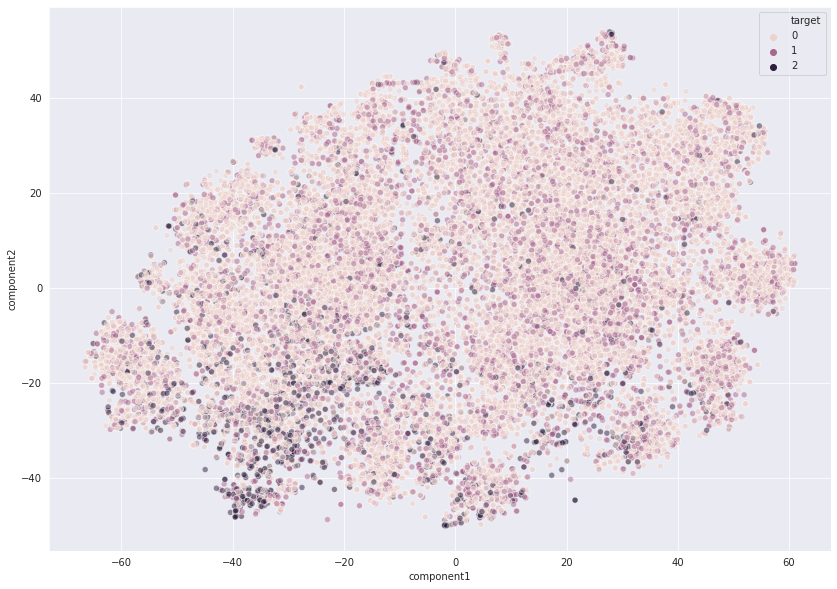

In [38]:
X_embedded = TSNE(n_components=2).fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_embedded,columns=["component1","component2"])
tsne_df['target'] = target
plt.figure(figsize=(14,10))
sns.scatterplot(data=tsne_df, x="component1", y="component2", hue="target",alpha=0.5)

Несмотря на то, что видны некоторые скопления, хочу отметить, что данная задача довольно сложна, на плоскости объекты практически не разделимы.

В результате из примерно 260 признаков мы получили только 69. Отмечу, однако, что в соревновании это эффекта не дало, даже наоборот. 

Сложные нелинейные алгоритмы на основе ансамблей из деревьев решений способны извлечь нелинейные зависимости из, на первый взгляд, даже ненужных признаков, а при удалении признаков это становится невозможным. 

Поэтому данные подходы по селекции я здесь помещаю скорее для информации. 